# Определение возраста покупателей

<b> План выполнения проекта: </b>
1. Провести исследовательский анализ набора фотографий.
2. Подготовить данные к обучению.
3. Обучить нейронную сеть и рассчитать её качество.

## Исследовательский анализ данных

In [2]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [4]:
labels.shape

(7591, 2)

In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


<Figure size 1080x720 with 0 Axes>

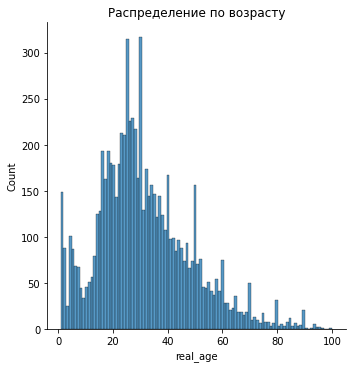

In [6]:
plt.figure(figsize=(15,10))
sns.displot(labels.real_age, kde=False, bins=100)
plt.title("Распределение по возрасту")
plt.show()

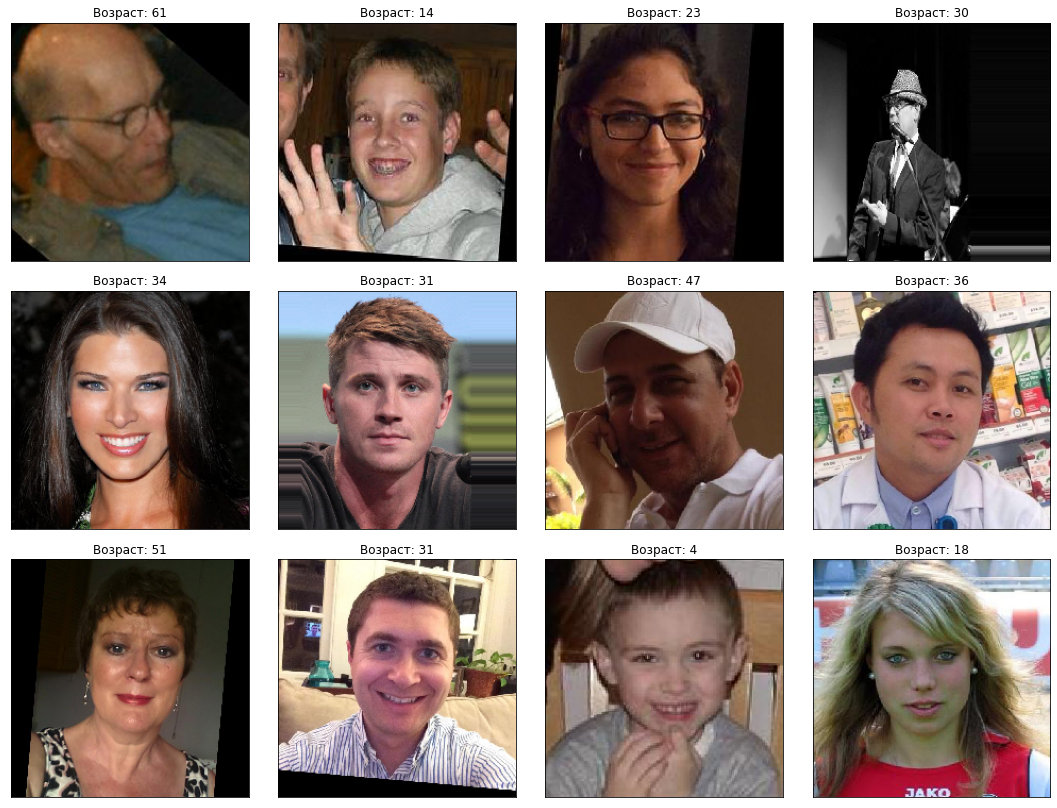

In [20]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(15,15))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title(f'Возраст: {target[i]}')

<b> Промежуточный вывод: </b>  


Фотографии неоднородны, как по степени освещённости и насыщенности цветов, так и по положению лица в кадре и его размеру. Часть фото чёрно-белые, часть цветные. Некоторые фотографии повёрнуты, иногда встречаются объекты, которые закрывают лицо.
Данные распределены по возрастам неравномерно, а это значит, что модель научится лучше определять возраст группы 20-30 лет.

## Обучение модели

### Код модели

```python
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

### Результат вывода на экран

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 54s - loss: 197.5380 - mae: 10.1784 - val_loss: 767.3758 - val_mae: 22.6931
Epoch 2/10
356/356 - 46s - loss: 80.1938 - mae: 6.8424 - val_loss: 138.2216 - val_mae: 8.8544
Epoch 3/10
356/356 - 45s - loss: 57.4179 - mae: 5.7937 - val_loss: 97.9846 - val_mae: 7.3827
Epoch 4/10
356/356 - 45s - loss: 41.7527 - mae: 4.9531 - val_loss: 96.1487 - val_mae: 7.7175
Epoch 5/10
356/356 - 43s - loss: 29.9828 - mae: 4.2519 - val_loss: 79.7631 - val_mae: 6.6676
Epoch 6/10
356/356 - 42s - loss: 26.1584 - mae: 3.8495 - val_loss: 77.5059 - val_mae: 6.7174
Epoch 7/10
356/356 - 42s - loss: 20.3795 - mae: 3.4382 - val_loss: 79.7531 - val_mae: 6.6329
Epoch 8/10
356/356 - 42s - loss: 16.2125 - mae: 3.0498 - val_loss: 68.6320 - val_mae: 6.4101
Epoch 9/10
356/356 - 41s - loss: 13.6133 - mae: 2.7963 - val_loss: 69.5352 - val_mae: 6.2876
Epoch 10/10
356/356 - 42s - loss: 12.1046 - mae: 2.6397 - val_loss: 60.7728 - val_mae: 5.7604

119/119 - 10s - loss: 60.7728 - mae: 5.7604
Test MAE: 5.7604
```

## Анализ обученной модели

Мы обучили модель, используя архитектуру ResNet50, которая позволяет с достаточной точностью предсказывать возраст покупателей.  За 10 эпох обучения удалось уменьшить MAE с 10.1784 до 5.7604 на тренировочной выборке. Значение МАЕ: 5.7604 - хороший показатель, модель с такой ошибкой вполне можно сравнить с ошибкой, которую может допустить человек.

Обучение нейронных сетей на GPU позволяет быстро и эффективно обработать большое количество информации с высокой точностью.